# Imports

In [1]:
# File R/W
import os

# Additional Inbuilt Utilities
import itertools
import functools

# Regex
import re

# Array
import numpy as np

# Table
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Advanced Computations
import scipy as sc

# Statistics
import statsmodels.api as sm

# Neurophysiological Data Analysis
import mne
import mne_nirs # esp. for fNIRS

# Vistual Display
from pyvirtualdisplay import Display

In [2]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

# Custom Settings
%aimport constants

# Custom Functions
%aimport utils

# Modified MBLL
%aimport mbll

# Custom Class
%aimport nirs
NIRS = nirs.NIRS

## Config

In [3]:
mne.set_log_level('WARNING')

In [4]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('qt') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

In [5]:
# Set recommended (by MNE) plotting backend
# %matplotlib qt

In [6]:
# Setup and start xvfb virtual display
# disp = Display()
# disp.start()

# MAIN

In [7]:
# Read some data and create instantiate NIRS()
nirs = NIRS().read(1, 1, 4, transform=False, remove_backlight=False)

In [8]:
# Pre-process the data using the default pipeline, with dpf/ppf as argument (default `constants.PPF`)
# Output is a dictionary of intermediate mne.Raw instances
# Stages: CW     (raw signal)
#         OD     (optical density)
#         TDD    (motion artifact removal)
#         SSR    (short-channel regression)
#         HB     (chromophore/haemoglobin)
#         FL     (bandpass filtering)
#         NCE    (negative correlation improvement)
savepoints = nirs.default_pipeline(ppf=0.1)

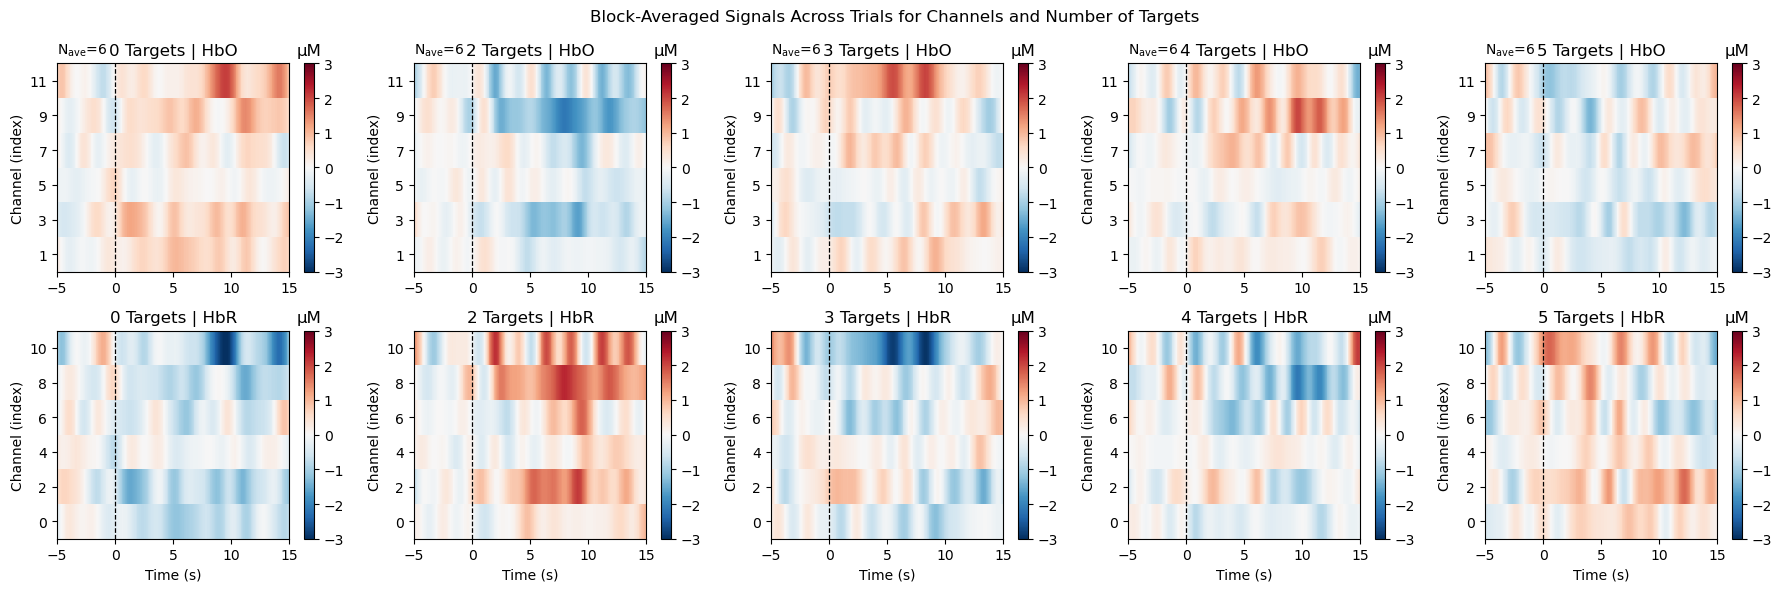

In [9]:
nirs.plot_average_heatmap(clim={'hbo': [-3, 3], 'hbr': [-3, 3]}).tight_layout()

---